# Aplicación de la transformación de blanqueo a los datos sintetizados

## Objetivos
* Aplicar una transformación de blanqueo a los datos con sobremuestreo en rango.
* Estimar la potencia, velocidad Doppler y ancho de banda Doppler. Comparativa entre los estimadores para los datos con correlación y sin correlación.
* Analizar la calidad de las estimaciones y aplicar criterios de decisión.


## Fundamentos

La varianza de los estimadores es inversamente proporcional a la cantidad de muestras independientes. Cuantas más muestras independientes se utilizan, menor la varianza de los estimadores.

La correlación en rango puede calcularse a priori y conociendo el coeficiente de correlación puede aplicarse una transformación de blanqueo. Dada la forma de envolvente del pulso por $p(l)$ y la respuesta impulsiva del receptor por $h(l)$:

 $$R_V ^{(R)}(m) = \sigma_s^2[p_m(m)\star p_m^*(-m)]$$

donde $p_m(m)=p(m)\star h(m)$ y el superíndice $(R)$ indica que hablamos de rango. El coeficiente de correlación es:
$$ \rho_v ^{(R)}(m)= \frac{R_V ^{(R)}(m)}{R_V ^{(R)}(0)}= \frac{p_m(m)\star p_m^*(-m)}{\sum_{l=0}^{L-1} p_m^2(l)} $$

Con dicho coeficiente se construye la matriz Toeplitz normalizada de correlación, $C_v$, y se aplica factorización de Cholesky para escribirla en la forma:
$$ C_v= HH^{*T} $$
donde $H$ es semidefinida positiva y es la inversa de la matriz de blanqueo:
$$ W = H^{-1} $$

Dicha matriz se aplica a los datos correlacionados en rango y produce L variables aleatorias descorrelacionadas de igual varianza: 
$$ X_n = W V_n $$
donde $X_n= [X(0,nT_s),X(1,nT_s), ...,X(L-1,nT_s)]^T$ son las muestras descorrelacionadas y $V_n= [V(0,nT_s),V(1,nT_s), ...,V(L-1,nT_s)]^T $ son las muestras producidas por el simulador de datos de radar meteorológico.



## Algoritmo
* Se calcula el coeficiente de correlación y se genera la matriz Toeplitz normalizada de correlación $C_v$.
* Se aplica la descomposición de Cholesky y se encuentra la matriz de blanqueo $W$.
* La función retorna las muestras blanqueadas $X(lt_0,nT_s)$


### Nota

* Se exporta la función que genera los datos sintetizados y se inicializan todas sus variables, para más información leer las notas de dicho notebook "Datos_sinteticos_radar_meteorologico.ipynb".




## Implementación


In [1]:
import numpy as np

def blanqueo(V, L, p_l, h_l):
    """
     ================================INPUTS===================================
    
    V          : señal de radar meteorológico sobremuestrado en rango.

    L          : factor de oversampling.
    
    p_l        : envolvente del pulso transmitido.

    h_l        : respuesta impulsional del receptor.

    ==============================OUTPUTS===============================
    
    X          : señal de radar meteorólogico sobremuestreado en rango blanqueada.
    C_v        : matriz Toepliz normalizada de correlación.
    """

    # Algoritmo de blanqueo

    ro= np.zeros(L)
    pm= np.convolve(p_l, h_l, "full") # Pm es la convolución de p_l con h_l
    ro= np.convolve(pm,np.conjugate(np.flip(pm)), "full")/(np.sum(pm**2)) # Coeficientes de correlación

    # Encuentro la matriz de correlación C_v^R

    U= np.zeros((L, L), dtype= 'complex_')
    U_conj= np.zeros((L, L), dtype= 'complex_')
    for mm in range(L):     
        U[mm,:]= U[mm,:] + np.roll(ro[-L:], mm)
 
    U= np.triu(U, 0)
    U_h= np.matrix.transpose(U)
    U_h= np.tril( U_h, -1)

    C_v= U + np.conjugate(U_h)  # Matriz de correlación

    # Descomponemos C_v y encontramos la matriz de blanqueo

    H= np.linalg.cholesky(C_v) # Descomposición de Cholesky

    W= np.linalg.inv(H) # Matriz de transformación de blanqueo

    X= np.dot(W, V) # Datos blanqueados

    # Salida

    return(X, C_v)

## Pruebas: 

* Generamos la señal de radar utilizando del simulador.
* Blanqueamos la señal generada y comparamos las autocorrelaciones.

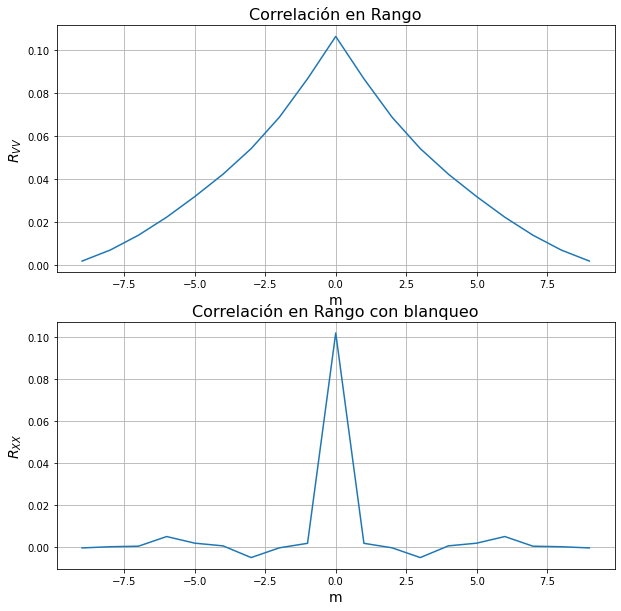

In [2]:
import numpy as np
from datos_sinteticos import datos_sinteticos
from matplotlib import pyplot as plt 

L= 10  # Factor de oversampling
F= 1   # Largo de la respuesta del filtro receptor
M= 256 # Cantidad de pulsos 
h_l= np.ones(F)  # Filtro receptor, una delta en nuestro caso ideal
p_l= np.ones(L) # L muestras del PULSO RECTANGULAR 
S = 10 # Potencia media de la señal de meteorológica, en dBm
sigma_v = 2 # Ancho de banda Doppler, en m/s
v_amax = 32 # Max velocidad ambigüa, en m/s
v_mean = 5 # Velocidad Doppler media, en m/s
Pn = -20  # Potencia de ruido, en dBm
lamb= 0.1 # Frecuencia de operanción, en m 

# Datos sintetizados

V= datos_sinteticos(M, L, F, p_l, h_l, S, Pn, v_mean, sigma_v, lamb, v_amax)

# Datos blanqueados

X, C_v= blanqueo(V, L, p_l, h_l)

# Gráficas 

x= np.arange(-L+1, L)

y= np.zeros(2*L-1, dtype= 'complex_')

y1= np.zeros(2*L-1, dtype= 'complex_')

for i in range(M):
    y += 1/M * np.correlate(V[:,i], V[:,i], "full") # Correlación en Rango sin traf. de blanqueo
    y1 += 1/M * np.correlate(X[:,i], X[:,i], "full") # Correlación en Rango con traf. de blanqueo


# Correlaciones 
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(x, np.real(y))
axs[0].set_xlabel('m', fontdict= {'size': 14})
axs[0].set_ylabel('$R_{VV}$',fontdict= {'size': 14} )
axs[0].set_title('Correlación en Rango', fontdict= {'size': 16})
axs[0].grid(True)

axs[1].plot(x, np.real(y1))
axs[1].set_xlabel('m', fontdict= {'size': 14})
axs[1].set_ylabel('$R_{XX}$', fontdict= {'size': 14})
axs[1].set_title('Correlación en Rango con blanqueo', fontdict= {'size': 16})
axs[1].grid(True)

plt.show()



## Conclusiones
* Se implementó el algoritmo de blanqueo a la señal de radar sobremuestreada en rango.
* Para poner a prueba el simulador, se anlizó un sistema ideal: ancho de banda infinito en el receptor, $h(l)=\delta (l)$, y pulso rectangular ideal de duración $\tau$.
* Se puede apreciar que la autocorrelación de la señal blanqueada se asemeja a una delta, como era de esperarse. Además, vemos que aplicar la transformación de blanqueo no modifica la potencia de la señal.

## Trabajo futuro

* Estimación de la potencia, velocidad Doppler y ancho de banda Doppler.
* Comparar los datos reales, los cuales son parámetros de entrada al simulador, con los estimados para las señales con blanqueo y sin blanqueo.
* Analizar criterios de decisión para optar por determinado estimador.

## Referencias

* Torres, S. and D.S.Zrinc, 2003: Whitening in Range to Improve Weather Radar Spectral Moment Estimates.
Part I: Formulation and Simulation. J. Atmos. Oceanic Technol., 20, 1433-1448.